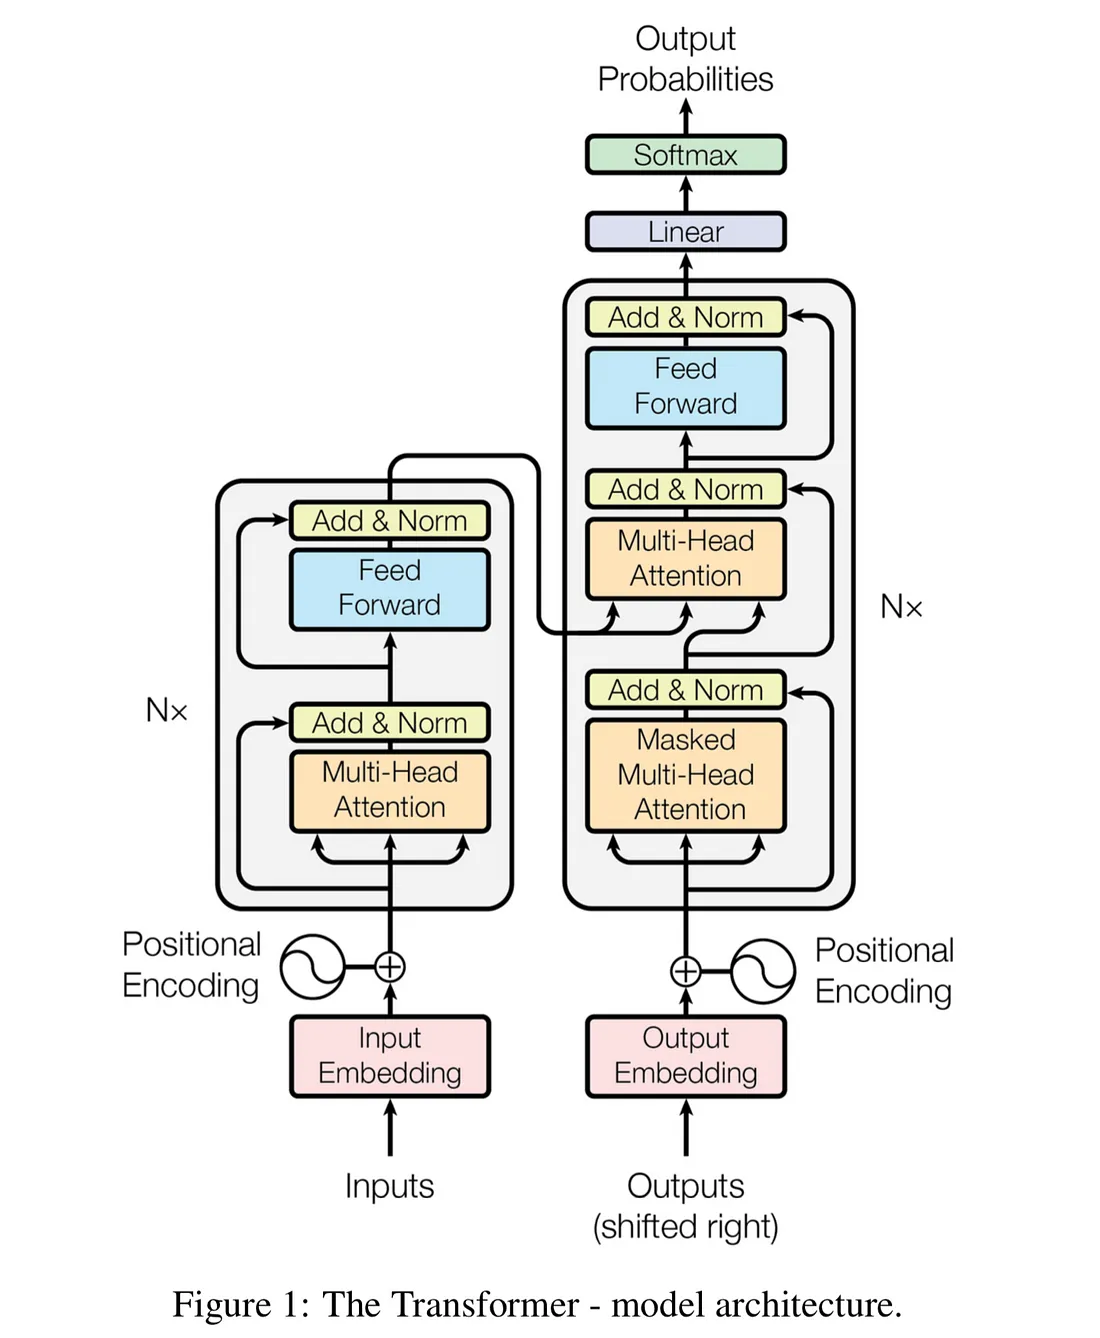

In [ ]:
!pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the base GPT-2 model and tokenizer.
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

def generate_text(prompt, max_length=100, temperature=0.7, top_k=50):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output_ids = model.generate(
        input_ids,
        do_sample=True,
        max_length=max_length,
        temperature=temperature,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Test the base model.
prompt = "The history of machine learning"
print("Base GPT-2 output:")
print(generate_text(prompt))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Base GPT-2 output:
The history of machine learning, and what we learn from them, is that we can learn from them and then do things we shouldn't. In the context of machine learning we can learn from how people act, and in the context of machine learning we can learn from how things themselves act.

Advertisement

The whole story is you're able to take advantage of the knowledge that you have. You know that there is a lot of data that you can learn from. So if we can learn


In [ ]:
# Test the base model.
prompt = "The legend begins"
print("Base GPT-2 output:")
print(generate_text(prompt))

Base GPT-2 output:
The legend begins with the arrival of a young man named Charles "Crazy" Brown, who had been a member of the British Royal Family during World War II. While on a mission in 1944, Brown was shot and killed while playing a game on his horse, and was left for dead.

The legend goes back to the beginning of the Civil War and begins with the arrival of some of the most powerful soldiers in the world. The legend begins with the arrival of some of the most powerful


In [ ]:
import os
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    TrainerCallback,
)
from datasets import load_dataset

# 1. Specify the model name and dataset file path.
model_name = "gpt2"
dataset_path = "rynaks_legend.txt"  # Replace with your file path if needed.

# 2. Load the GPT-2 tokenizer and model.
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set pad token if not already set.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 3. Load the text dataset.
dataset = load_dataset("text", data_files={"train": dataset_path})

# 4. Define a function to tokenize each example.
def tokenize_function(examples):
    # Truncate to a maximum of 512 tokens for efficiency.
    return tokenizer(examples["text"], truncation=True, max_length=512)

# Tokenize the entire dataset.
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# 5. Filter out any examples with empty input_ids to avoid errors.
# It ensures that all examples contain valid tokens (avoids empty text inputs that can cause errors).
def filter_empty(example):
    return len(example["input_ids"]) > 0

tokenized_datasets = tokenized_datasets.filter(filter_empty)

# 6. Set up a DataCollator.
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# 7. Define training arguments with TensorBoard logging disabled.
training_args = TrainingArguments(
    output_dir="./gpt2_finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_steps=1,
    logging_dir="./logs",
    report_to=[],  # Disable TensorBoard logging to avoid the error
)

# 8. Custom callback to log training progress correctly.
class CustomProgressCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            print(
                f"Epoch: {state.epoch:.2f}, Step: {state.global_step}, Loss: {logs['loss']:.4f}"
            )

# 9. Initialize the Trainer without passing the deprecated 'tokenizer' parameter.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    data_collator=data_collator,
    callbacks=[CustomProgressCallback()],
)

# 10. Start fine-tuning and capture the training output.
train_output = trainer.train()

# 11. Print training time metrics.
print("Training metrics:")
print(f"  Total Steps: {train_output.global_step}")
print(f"  Total Training Loss: {train_output.training_loss:.4f}")
# print(f"  Training runtime: {trainer.state.train_runtime:.2f} seconds")
# print(f"  Samples per second: {trainer.state.samples_per_second:.2f}")
# print(f"  Steps per second: {trainer.state.steps_per_second:.2f}")

# 12. Save the fine-tuned model and tokenizer.
model.save_pretrained("./gpt2_finetuned")
tokenizer.save_pretrained("./gpt2_finetuned")



Step,Training Loss
1,4.822500
2,5.079600
3,4.401400
4,4.354400
5,4.042300
6,6.088100
7,3.709800
8,3.827000
9,3.535700
10,4.020200


Epoch: 0.17, Step: 1, Loss: 4.8225
Epoch: 0.33, Step: 2, Loss: 5.0796
Epoch: 0.50, Step: 3, Loss: 4.4014
Epoch: 0.67, Step: 4, Loss: 4.3544
Epoch: 0.83, Step: 5, Loss: 4.0423
Epoch: 1.00, Step: 6, Loss: 6.0881
Epoch: 1.17, Step: 7, Loss: 3.7098
Epoch: 1.33, Step: 8, Loss: 3.8270
Epoch: 1.50, Step: 9, Loss: 3.5357
Epoch: 1.67, Step: 10, Loss: 4.0202
Epoch: 1.83, Step: 11, Loss: 3.7290
Epoch: 2.00, Step: 12, Loss: 3.1443
Epoch: 2.17, Step: 13, Loss: 3.1927
Epoch: 2.33, Step: 14, Loss: 2.8838
Epoch: 2.50, Step: 15, Loss: 3.3533
Epoch: 2.67, Step: 16, Loss: 3.0268
Epoch: 2.83, Step: 17, Loss: 3.5466
Epoch: 3.00, Step: 18, Loss: 3.2568
Training metrics:
  Total Steps: 18
  Total Training Loss: 3.8897


('./gpt2_finetuned/tokenizer_config.json',
 './gpt2_finetuned/special_tokens_map.json',
 './gpt2_finetuned/vocab.json',
 './gpt2_finetuned/merges.txt',
 './gpt2_finetuned/added_tokens.json')

In [ ]:
import torch

# Detect the available device (TPU, CUDA, or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the correct device
model.to(device)

def generate_text(prompt, max_length=100, temperature=0.7, top_k=50):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)  # Move input to the same device as model

    output_ids = model.generate(
        input_ids,
        do_sample=True,
        max_length=max_length,
        temperature=temperature,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [ ]:
# Test the fine-tuned model.
print("Fine-tuned GPT-2 output:")
print(generate_text("The legend begins"))

Fine-tuned GPT-2 output:
The legend begins

The spirit of the dragon comes forth, and Themis comes forth, and Themis grows restless. The dragon comes forth, and the dragon comes forth, and Themis grows restless. The dragons rise from the grave and rise, and the sun rises from the sea. The dragon rises, and the sun rises. The dragon rises, and Themis rises. The dragon risen. The dragon rises, and Themis rises. The dragon rises, and Themis rises. The
